In [1]:
import sys
sys.path.append('/home/dominhnhat/Classroom/deepul')
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')
ptu.set_gpu_mode(True)
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
batch_size = 256
lr = 2e-4
beta = (0.0, 0.9)
decay_rate = 10
n_critic = 5
device = 'cuda'

class MyImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image

transform = transforms.Compose([
    transforms.ToTensor(),
])

data_dir = '/home/dominhnhat/Classroom/generative_model/data/CIFAR_32/train'
dataset = MyImageDataset(image_dir=data_dir, transform=transform)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [3]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output.contiguous()


class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
        self.Depth2Space = DepthToSpace(2)

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = self.Depth2Space(x)
        x = self.conv(x)
        return x
    
class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
        self.Space2Depth = SpaceToDepth(2)

    def forward(self, x):
        x = self.Space2Depth(x)
        #print(x.chunk(4, dim=1).shape)
        #print(type(x))
        #print(x.chunk(4, dim=1)[1])
        #print(x.chunk(4, dim=1)[0])
        #print(type(x.chunk(4, dim=1)))
        x = sum(x.chunk(4, dim=1)) / 4.0
        x = self.conv(x)
        return x

class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        ) 
        self.shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
    
    def forward(self, x):
        return self.shortcut(x) + self.net(x)

class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.ReLU(),
            Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        ) 
        self.shortcut = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
    
    def forward(self, x):
        return self.shortcut(x) + self.net(x)

class Generator(nn.Module):
    def __init__(self, n_filters = 128):
        super().__init__()
        self.fc = nn.Linear(128, 4*4*256)
        self.net = nn.Sequential(
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.fc(x).reshape(-1, 256, 4, 4)
        return self.net(x)
    
    def sample(self, n_samples):
        z = torch.randn(n_samples, 128).to(device)
        return torch.clamp(self.forward(z), 0, 1)

class ResnetBlock(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super(ResnetBlock, self).__init__()
        self.layers = nn.ModuleList([
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, padding=1)
        ])

    def forward(self, x):
        _x = x
        for op in self.layers:
            _x = op(_x)
        return x + _x

class Discriminator(nn.Module):
    def __init__(self, n_filters = 128):
        super().__init__()
        self.net = nn.Sequential(
            ResnetBlockDown(3, n_filters=128),
            ResnetBlockDown(128, n_filters=128),
            ResnetBlock(128, n_filters=128),
            ResnetBlock(128, n_filters=128),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.net(x)
        return self.fc(x)

def generator_loss(gen : Generator, dis : Discriminator, x):
    fake_data = gen.sample(x.shape[0])
    return (1 - dis(fake_data)).log().mean()

def discriminator_loss(gen : Generator, dis : Discriminator, x):
    fake_data = gen.sample(x.shape[0])
    return - (1 - dis(fake_data)).log().mean() - dis(x).log().mean()

G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=beta)
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=beta)

def train_epoch(G, D, dataloader, n_crit = n_critic, debug = True):

    epoch_d_loss = []


    for i, X in enumerate(dataloader):
        X = X.to(device)

        D.train()
        G.train()

        d_loss = discriminator_loss(G, D, X)
        D_optimizer.zero_grad()
        d_loss.backward()
        D_optimizer.step()

        if ((i + 1) % n_crit == 0):
            g_loss = generator_loss(G, D, X)
            G_optimizer.zero_grad()
            g_loss.backward()
            G_optimizer.step()

            if (debug == True and i % 50 == 0):
                print(f'Batch number {i} || D loss : {d_loss} || G loss : {g_loss}')
        
        epoch_d_loss.append(d_loss.detach().cpu().numpy())
    
    return epoch_d_loss

def train(G, D, dataloader, epochs, debug = True):
    training_loss = []   
    for epoch in range(0, epochs):
        if (debug == True):
            print(f'epoch number {epoch} : ' + '-'*30)

        epoch_d_loss = train_epoch(G, D, dataloader, debug)
        for i in epoch_d_loss:
            training_loss.append(i)
    
    return np.array(training_loss)

training_loss = train(G, D, train_dataloader, 30)

epoch number 0 : ------------------------------
Batch number 0 || D loss : 1.398470163345337 || G loss : -0.5610932111740112
Batch number 50 || D loss : 1.3507757186889648 || G loss : -0.6164116263389587
Batch number 100 || D loss : 1.3925443887710571 || G loss : -0.718903660774231
Batch number 150 || D loss : 1.3895988464355469 || G loss : -0.63840252161026
epoch number 1 : ------------------------------
Batch number 0 || D loss : 1.3872495889663696 || G loss : -0.7021852731704712
Batch number 50 || D loss : 1.3859062194824219 || G loss : -0.6951084136962891
Batch number 100 || D loss : 1.3912057876586914 || G loss : -0.6703782081604004
Batch number 150 || D loss : 1.3884789943695068 || G loss : -0.6892139911651611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022493372..0.9636282].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008727232..0.9833185].


(10, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14126146..0.98173326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14737983..0.9994228].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.030380143..0.9967085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1687766..0.96938056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.035641212..0.9850508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.080418974..0.9989856].


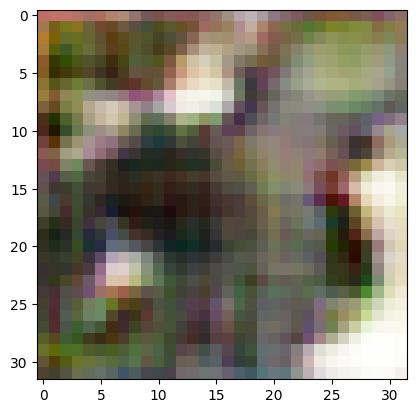

In [15]:
generated_images = G.sample(10).permute(0, 2, 3, 1).to('cpu').detach().numpy()
print(generated_images.shape)
for i, image in enumerate(generated_images):
    plt.imshow(image)
    path = '/home/dominhnhat/Classroom/generative_model/SNGAN-cifar/result/' + str(i + 1) + '.jpg'
    plt.savefig(path)